In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from utils.config import opt
from utils.data_load import save_pkl, load_pkl
import numpy as np
from torch import nn

# VOCDataset

In [5]:
from utils.data_load import VOCDataset

In [6]:
dataset = VOCDataset(opt, train=True)

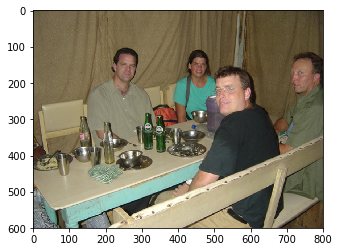

In [7]:
img, bbox, label, scale = dataset.__getitem__(25)
plt.imshow(((img*np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))*255).astype("uint8"))

In [5]:
img.shape

(600, 800, 3)

In [6]:
img_size = img.shape[:2]

In [7]:
img_size

(600, 800)

# Network

In [8]:
from torch.autograd import Variable 
import torch as t

## extractor

In [9]:
from model.vgg16 import decom_vgg16

In [10]:
extractor, classifier = decom_vgg16()

In [11]:
img_t = Variable(t.from_numpy(img.transpose([2,0,1])))
img_t[None].shape

torch.Size([1, 3, 600, 800])

In [12]:
h = extractor(img_t[None])

In [13]:
h.shape

torch.Size([1, 512, 37, 50])

## rpn

In [14]:
from model.rpn import RegionProposalNetwork

In [15]:
rpn = RegionProposalNetwork()

In [16]:
img_size

(600, 800)

In [17]:
rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn(h, img_size)

## head

In [9]:
from model.roi_module import VGG16RoIHead
from utils import array_tool as at

In [22]:
d = load_pkl("/home/guangyaoyang/Desktop/d.pkl")
h = d["h"]
rois = d["rois"]
roi_indices = d["roi_indices"]

In [23]:
head = VGG16RoIHead(21, 7, 1/16, classifier)

In [24]:
head(h, rois, roi_indices)

(Variable containing:
  2.6399e-02 -3.7926e-02  8.9815e-03  ...   1.6473e-02  6.5912e-02 -8.0381e-03
  8.8971e-03 -1.7879e-02 -2.1583e-02  ...   5.2627e-02  1.1867e-02 -3.1350e-02
 -7.3621e-05 -6.3509e-03 -5.6004e-02  ...   6.2664e-02  4.5975e-02 -2.9097e-02
                 ...                   ⋱                   ...                
  1.7110e-02 -4.0621e-03 -1.5166e-02  ...   6.0593e-02  2.6223e-02 -4.0164e-02
 -1.1605e-02 -1.2345e-02 -4.9552e-02  ...   1.0611e-02  3.4927e-02 -2.7766e-02
  8.0808e-03 -4.1443e-02  8.3821e-03  ...   2.3460e-02  5.4238e-02  4.5027e-03
 [torch.cuda.FloatTensor of size 300x84 (GPU 0)], Variable containing:
 -0.4462  0.1766  0.4917  ...   0.7982  0.1991 -0.7374
 -0.5978  0.0950 -0.2622  ...   0.1960  0.6905 -0.3187
 -0.0512  0.1747 -0.0398  ...   0.6517 -0.0711 -0.7256
           ...             ⋱             ...          
 -0.4033  0.1450 -0.0779  ...   0.2455  0.6827 -0.3062
 -0.0666  0.3511 -0.0348  ...   0.5350 -0.0971 -0.3004
  0.0128  0.3546  0.2893

## Faster-RCNN

In [45]:
from model.faster_rcnn import FasterRCNN

In [46]:
fasterrcnn = FasterRCNN()

In [40]:
img_v = Variable(t.from_numpy(img.transpose([2,0,1])[None]).cuda())

In [105]:
roi_cls_locs, roi_scores, rois, roi_indices = fasterrcnn(img_v)

In [14]:
img2 = img.transpose([2,0,1])[None]

In [47]:
fasterrcnn.predict(img2, [[600/1.6, 800/1.6]])

([array([[ 145.38885498,  122.96084595,  225.75665283,  205.99377441],
         [  51.15549469,   73.20357513,  226.29754639,  231.12710571],
         [ 197.77842712,  120.60902405,  244.3188324 ,  237.68812561],
         ..., 
         [  95.57875824,  191.89581299,  258.62835693,  346.25439453],
         [ 204.26098633,   63.44485474,  375.        ,  224.64846802],
         [ 148.39613342,    3.44004822,  280.55609131,  250.37541199]], dtype=float32)],
 [array([ 0,  0,  0, ..., 19, 19, 19], dtype=int32)],
 [array([ 0.10271481,  0.07897337,  0.07751655, ...,  0.05063707,
          0.05022397,  0.05005198], dtype=float32)])

# Trainer

In [94]:
from trainer.trainer import FasterRCNNTrainer

In [95]:
trainer = FasterRCNNTrainer(fasterrcnn)

In [1]:
imgs.shape

NameError: name 'imgs' is not defined

In [99]:
trainer.train_step(imgs, bboxes, labels, 1.6)

LossTuple(rpn_loc_loss=Variable containing:
 0.5123
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, rpn_cls_loss=Variable containing:
 0.6691
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, roi_loc_loss=Variable containing:
 0.5485
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, roi_cls_loss=Variable containing:
 2.8378
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, total_loss=Variable containing:
 4.5676
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)

In [17]:
from torch.utils import data as data_

In [19]:
dataloader = data_.DataLoader(dataset, \
                              batch_size=1, \
                              shuffle=True)

In [23]:
img

array([[[-0.43967801, -0.42506999, -0.7586928 ],
        [-0.44717011, -0.43272933, -0.76631808],
        [-0.45894334, -0.44476548, -0.7783007 ],
        ..., 
        [-1.18460488, -1.2041316 , -1.30444443],
        [-1.1257385 , -1.13410366, -1.28701532],
        [-1.07329392, -1.07282913, -1.26413941]],

       [[-0.43967801, -0.46336663, -0.76631808],
        [-0.44389239, -0.46767494, -0.77060729],
        [-0.45051488, -0.47444525, -0.77734745],
        ..., 
        [-1.1218586 , -1.13998497, -1.24058282],
        [-1.0878098 , -1.09532833, -1.24841237],
        [-1.05830979, -1.0575105 , -1.24888885]],

       [[-0.43325621, -0.50932246, -0.7717647 ],
        [-0.43606582, -0.51219469, -0.77462423],
        [-0.43941045, -0.51561409, -0.77802837],
        ..., 
        [-1.04419518, -1.06058788, -1.16153872],
        [-1.04165328, -1.04937255, -1.20204794],
        [-1.04118502, -1.04219186, -1.23254895]],

       ..., 
       [[-0.80678993, -0.372549  , -0.0397386 ],
        